In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dropout, Dense, Embedding, LSTM, Bidirectional
import pandas as pd
from pandas import get_dummies
import json
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression

In [2]:
DATA_LOC = 'data/'
FILE_NAME = 'data_train.json'

# Load in JSON files and extract from JSON
reviews_json = open(DATA_LOC + FILE_NAME, 'r')
reviews = json.load(reviews_json)

In [3]:
# Analyze the distribution of stars and reviews as seperate lists
texts = [review['text'] for review in reviews] # Features
stars = [review['stars'] for review in reviews] # Labels

In [4]:
# Balance a dataset to remove over-represented samples

from collections import Counter
def balance_classes(texts, stars):
    freqs = Counter(stars)

    # the least common class is the maximum number we want for all classes
    maxAllowable = freqs.most_common()[-1][1]
    numAdded = {clss: 0 for clss in freqs.keys()}
    newStars = []
    newTexts = []
    for i, star in enumerate(stars):
        if numAdded[star] < maxAllowable:
            newStars.append(star)
            newTexts.append(texts[i])
            numAdded[star] += 1
    return newTexts, newStars

In [5]:
balanced_texts, balanced_stars = balance_classes(texts, stars)
print("Distributions before and after dataset balancing\nNon-Balanced: {}\nBalanced: {}".format(Counter(stars), 
                                       Counter(balanced_stars)))

Distributions before and after dataset balancing
Non-Balanced: Counter({5.0: 147645, 4.0: 73604, 1.0: 49031, 3.0: 36987, 2.0: 27028})
Balanced: Counter({1.0: 27028, 5.0: 27028, 4.0: 27028, 3.0: 27028, 2.0: 27028})


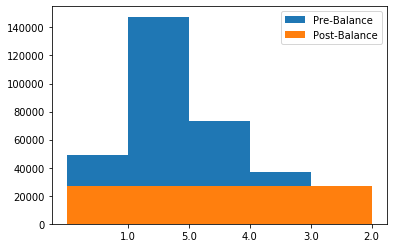

In [6]:
# Look at distributions before and after dataset balancing
pre_labels, pre_values = zip(*Counter(stars).items())
post_labels, post_values = zip(*Counter(balanced_stars).items())
pre_indexes = np.arange(len(pre_labels))
post_indexes = np.arange(len(post_labels))
width = 1

plt.bar(pre_indexes, pre_values, width)
plt.bar(post_indexes, post_values, width)
plt.xticks(pre_indexes + width * 0.5, pre_labels)
plt.legend(['Pre-Balance', 'Post-Balance'])

plt.show()

In [7]:
# Save pre and post balanced datasets as numpy.save()
from tempfile import TemporaryFile

preBal = TemporaryFile()
postBal = TemporaryFile()

np.save(preBal, stars)
np.save(postBal, balanced_stars)

In [8]:
# Split files into training and testing sets
vectorizer = TfidfVectorizer(ngram_range=(1,2))
vectors = vectorizer.fit_transform(balanced_texts)
X_train, X_test, y_train, y_test = train_test_split(vectors, balanced_stars, test_size=0.33, random_state=42)

In [9]:
#################### Train and Stack ############################

In [10]:
def lstm_model(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'], num_units = 128, embedding_size = 16):
    model = tf.keras.Sequential()
    model.add(Embedding(input_dim = 10000, output_dim = embedding_size, input_length = 1050))
    model.add(Bidirectional(LSTM(num_units)))
    model.add(Dense(1, activation = 'softmax'))
    model.compile(optimizer = optimizer, loss = loss, metrics = metrics)
    return model

In [11]:
from mlxtend.classifier import StackingClassifier

svm_clf = LinearSVC()
lstm_clf = lstm_model()
lr = LogisticRegression()
sclf = StackingClassifier(classifiers=[svm_clf, lstm_clf],
                         meta_classifier=lr)

/Users/oasysokubo/opt/miniconda3/envs/py37/lib/python3.7/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


In [12]:
svm_clf.fit(X_train, y_train)
# lstm_clf.fit(X_train, y_train)
# sclf.fit(X_train, y_train)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

In [13]:
# Predict the trained and fitted model on the test set
predictions = svm_clf.predict(X_test)

In [14]:
# Model's Accuracy Report of SVM
print(accuracy_score(y_test, predictions))

0.6079556920869117


In [15]:
# Classification Report of SVM


print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

         1.0       0.70      0.78      0.74      8853
         2.0       0.54      0.50      0.52      8892
         3.0       0.52      0.48      0.50      8911
         4.0       0.55      0.51      0.53      8987
         5.0       0.70      0.77      0.73      8954

    accuracy                           0.61     44597
   macro avg       0.60      0.61      0.60     44597
weighted avg       0.60      0.61      0.60     44597



In [16]:
# Confusion Matrix
# Rows: Predictions
# Cols: Correct class

print(confusion_matrix(y_test, predictions))

[[6906 1554  256   45   92]
 [2183 4461 1796  304  148]
 [ 533 1874 4279 1806  419]
 [ 132  331 1677 4588 2259]
 [ 100   64  248 1663 6879]]
